In [3]:
import scanpy as sc
import anndata as ad

In [2]:
adata_B197_epi = sc.read_h5ad("/home/augusta/SSS_mount/insituCNV/data/WTx-CosMx_TVA/snPATHO-seq/adata_lab_lv2-B-1970164-01-04_2,epi.h5ad")
adata_B197_imm = sc.read_h5ad("/home/augusta/SSS_mount/insituCNV/data/WTx-CosMx_TVA/snPATHO-seq/adata_lab_lv2-B-1970164-01-04_2,imm.h5ad")
adata_B197_str = sc.read_h5ad("/home/augusta/SSS_mount/insituCNV/data/WTx-CosMx_TVA/snPATHO-seq/adata_lab_lv2-B-1970164-01-04_2,str.h5ad")

In [ ]:
adatas = {'epi': adata_B197_epi,
          'imm': adata_B197_imm,
          'str': adata_B197_str}

In [8]:
adata = ad.concat(adatas, join="outer", label = 'dataset', index_unique="_", merge='same')

In [9]:
adata

AnnData object with n_obs × n_vars = 39075 × 15502
    obs: 'library', 'barcode', 'sid', 'sum', 'detected', 'subsets_mt_sum', 'subsets_mt_detected', 'subsets_mt_percent', 'total', 'sizeFactor', 'kid_lv1', 'lab_lv1', 'kid_lv2', 'lab_lv2', 'dataset'
    var: 'gene_id', 'gene_symbol'
    obsm: 'PCA', 'UMAP'
    layers: 'logcounts'

#### Add genomic positions

In [18]:
import pandas as pd

def add_genomic_positions(adata):
    ''' Adds gene positions to the AnnData object. The adata.var_names have to be EnsmblIDs. The data is taken from the Ensmbl BioMart human dataset GRCh38.p14. 

    param:
        adata (AnnData object): the annotated dataset where the gene postions should be added
    output: 
        adata (AnnData object): the annotated dataset where the genes are added
 
    '''

    
    # Load the gene positions data
    gene_file = ("/home/augusta/SSS_mount/insituCNV/InSituCNV/Ensmbl_BioMart_gene_info.txt")
    gene_positions_df = pd.read_csv(gene_file)

    # Create a dictionary for quick lookup
    gene_dict = gene_positions_df.set_index("Gene stable ID")[["Chromosome/scaffold name", "Gene start (bp)", "Gene end (bp)"]].to_dict("index")

    # Format chromosome names
    format_chromosome = lambda x: f"chr{x}"

    # Initialize counters
    genes_identified = 0

    # Iterate over the genes in adata
    for gene_id in adata.var_names:
        if gene_id in gene_dict:
            info = gene_dict[gene_id]
            adata.var.loc[gene_id, ["chromosome", "start", "end"]] = [format_chromosome(info["Chromosome/scaffold name"]), info["Gene start (bp)"], info["Gene end (bp)"]]
            genes_identified += 1

    # Print summary of identified genes
    print(f"{genes_identified} gene positions identified \n{adata.shape[1] - genes_identified} were not found")
    return adata

In [15]:
adata.var_names = adata.var.gene_id

In [19]:
add_genomic_positions(adata)

14928 gene positions identified 
574 were not found


AnnData object with n_obs × n_vars = 39075 × 15502
    obs: 'library', 'barcode', 'sid', 'sum', 'detected', 'subsets_mt_sum', 'subsets_mt_detected', 'subsets_mt_percent', 'total', 'sizeFactor', 'kid_lv1', 'lab_lv1', 'kid_lv2', 'lab_lv2', 'dataset'
    var: 'gene_id', 'gene_symbol', 'chromosome', 'start', 'end'
    obsm: 'PCA', 'UMAP'
    layers: 'logcounts'

#### Run preprocessing

In [22]:
sc.pp.calculate_qc_metrics(adata, inplace=True)

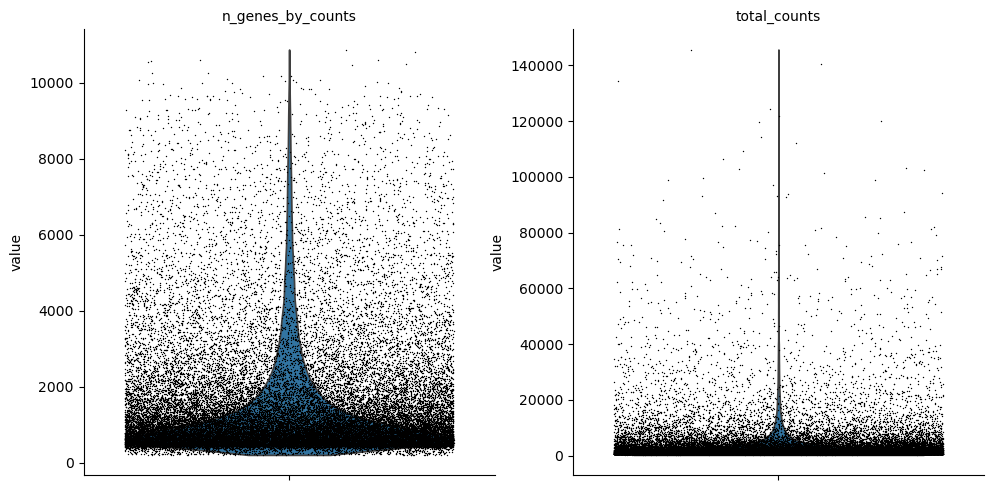

In [23]:
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts"],
    jitter=0.4,
    multi_panel=True,
)

In [25]:
# Saving raw data
adata.layers["raw"] = adata.X.copy()

In [26]:
# Normalizing to median total counts
sc.pp.normalize_total(adata)
# Logarithmize the data
sc.pp.log1p(adata)

In [28]:
sc.pp.highly_variable_genes(adata, n_top_genes=2000, batch_key="dataset")

In [29]:
sc.tl.pca(adata)

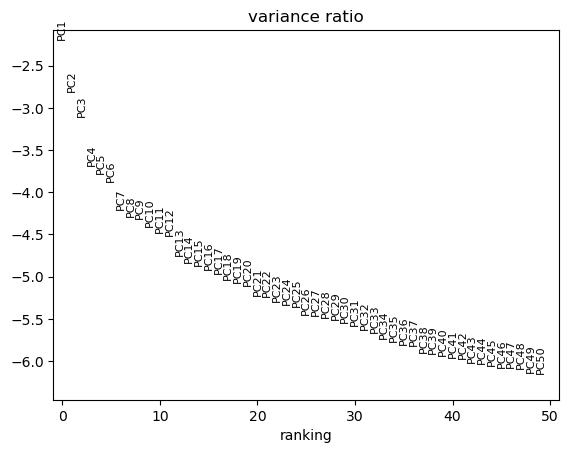

In [30]:
sc.pl.pca_variance_ratio(adata, n_pcs=50, log=True)

In [31]:
adata

AnnData object with n_obs × n_vars = 39075 × 15502
    obs: 'library', 'barcode', 'sid', 'sum', 'detected', 'subsets_mt_sum', 'subsets_mt_detected', 'subsets_mt_percent', 'total', 'sizeFactor', 'kid_lv1', 'lab_lv1', 'kid_lv2', 'lab_lv2', 'dataset', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'gene_id', 'gene_symbol', 'chromosome', 'start', 'end', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'PCA', 'UMAP', 'X_pca'
    varm: 'PCs'
    layers: 'logcounts', 'raw'

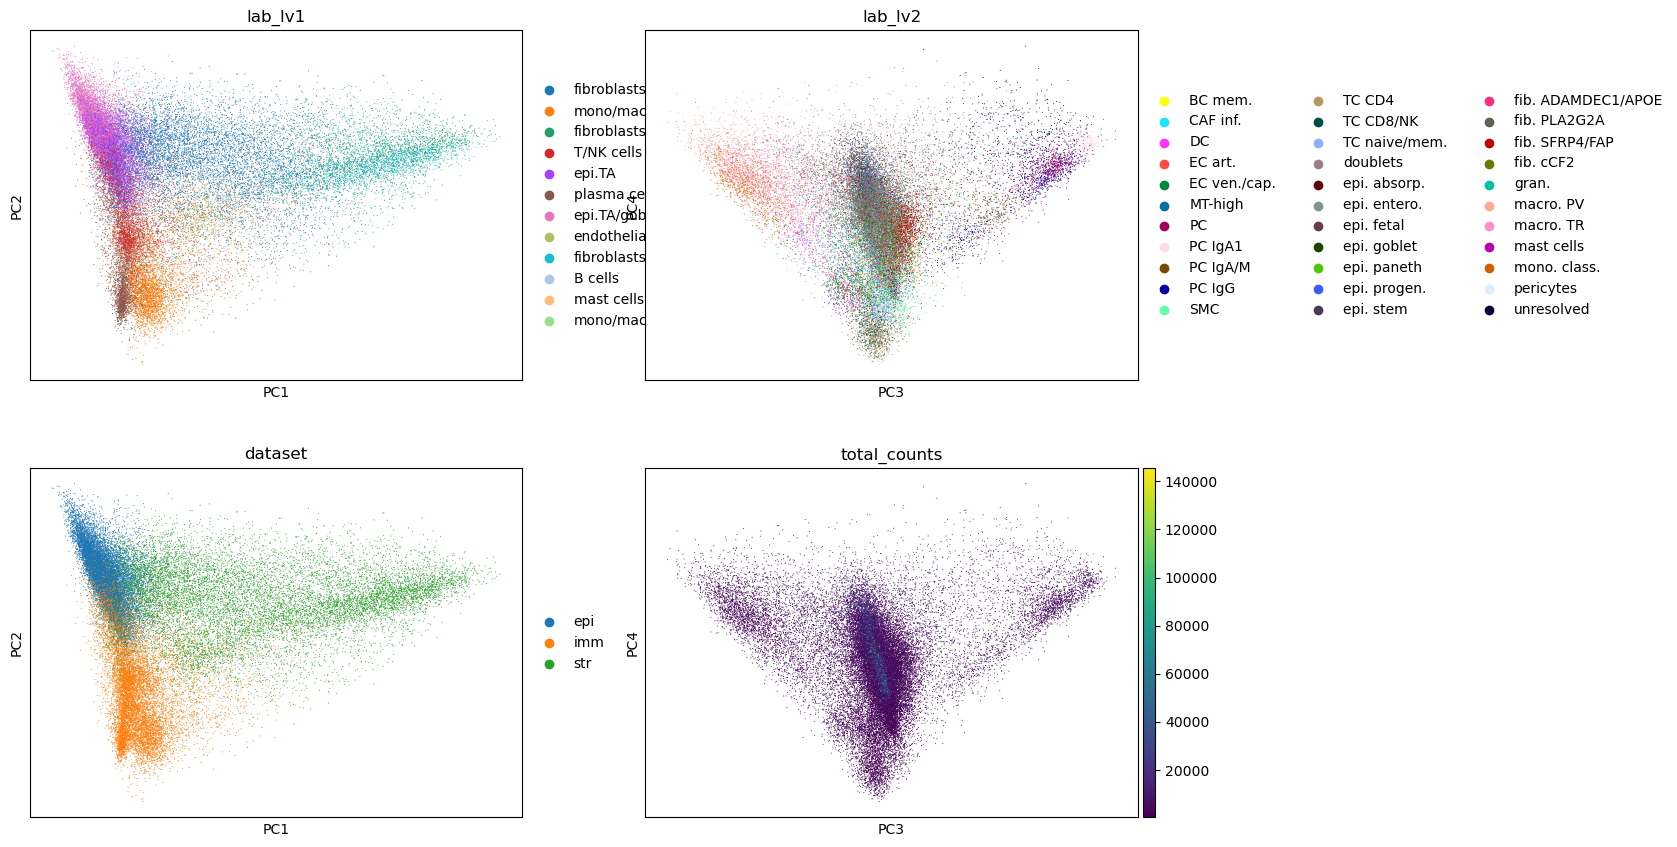

In [32]:
sc.pl.pca(
    adata,
    color=["lab_lv1", "lab_lv2", "dataset", "total_counts"],
    dimensions=[(0, 1), (2, 3), (0, 1), (2, 3)],
    ncols=2,
    size=2,
)

In [33]:
sc.pp.neighbors(adata)

In [34]:
sc.tl.umap(adata)

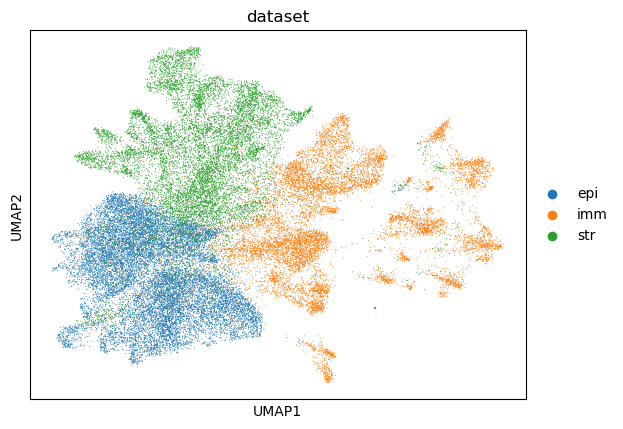

In [35]:
sc.pl.umap(
    adata,
    color="dataset",
    # Setting a smaller point size to get prevent overlap
    size=2,
)

#### Clustering

In [36]:
# Using the igraph implementation and a fixed number of iterations can be significantly faster, especially for larger datasets
sc.tl.leiden(adata, flavor="igraph", n_iterations=2)

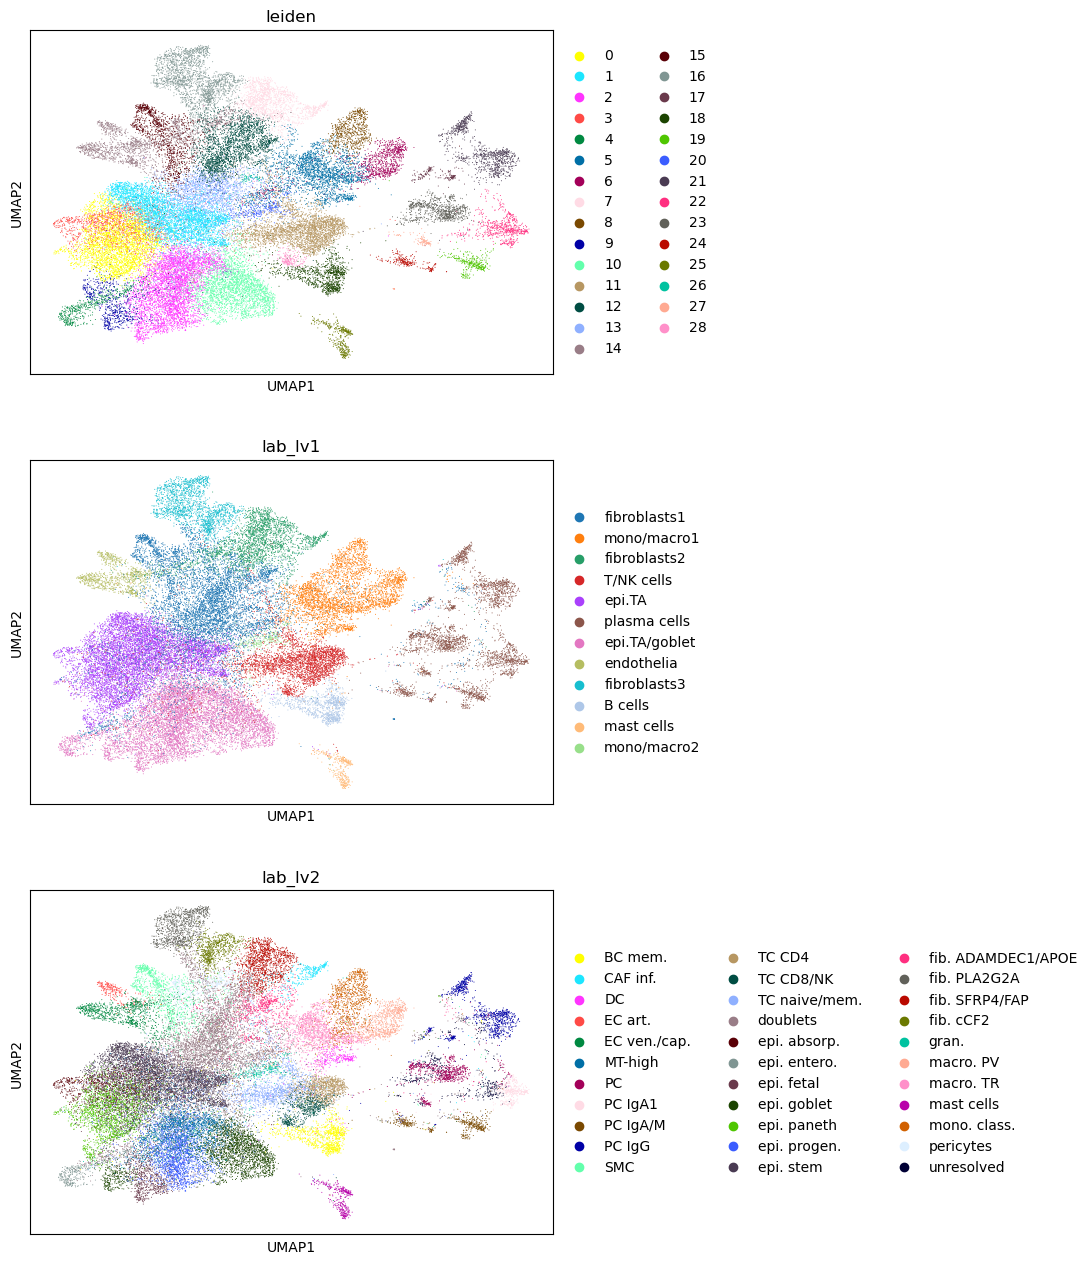

In [39]:
sc.pl.umap(
    adata,
    color=["leiden","lab_lv1", "lab_lv2"],
    # Setting a smaller point size to get prevent overlap
    size=2,
    ncols=1
)

In [38]:
adata.write_h5ad("/home/augusta/SSS_mount/insituCNV/data/WTx-CosMx_TVA/snPATHO-seq/adata_snPATHOseq_B197.h5ad", compression='gzip')